In [1]:
import pandas as pd
df = pd.read_csv("Fraud.csv") 
df.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [2]:
df['isFraud'].value_counts(normalize=True)


isFraud
0    0.998709
1    0.001291
Name: proportion, dtype: float64

([0, 1, 2, 3, 4],
 [Text(0, 0, 'PAYMENT'),
  Text(1, 0, 'TRANSFER'),
  Text(2, 0, 'CASH_OUT'),
  Text(3, 0, 'DEBIT'),
  Text(4, 0, 'CASH_IN')])

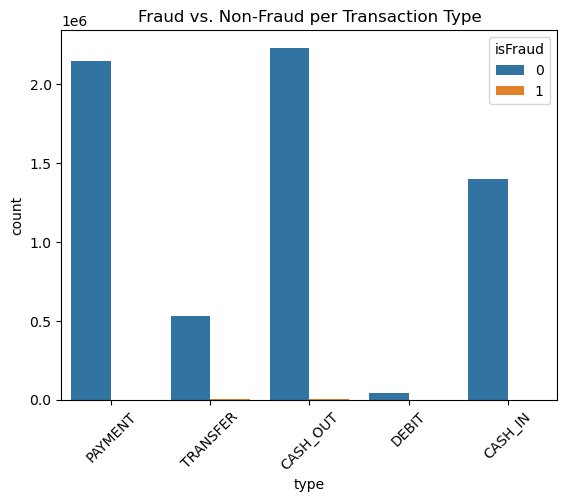

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=df, x='type', hue='isFraud')
plt.title("Fraud vs. Non-Fraud per Transaction Type")
plt.xticks(rotation=45)


In [4]:
# Error in balances - often manipulated in fraud
df['errorBalanceOrig'] = df.oldbalanceOrg - df.amount - df.newbalanceOrig
df['errorBalanceDest'] = df.oldbalanceDest + df.amount - df.newbalanceDest

# Encode categorical 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

# Drop IDs and flags we won’t use
df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

# Handle missing values
df.fillna(0, inplace=True)


In [5]:
from sklearn.model_selection import train_test_split

X = df.drop('isFraud', axis=1)
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [6]:
%%time

import lightgbm as lgb
import numpy as np

# Calculate scale_pos_weight for handling class imbalance
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos

# Build the model
model = lgb.LGBMClassifier(
    objective='binary',
    boosting_type='gbdt',
    scale_pos_weight=scale_pos_weight,
    n_estimators=300,
    learning_rate=0.05,
    max_depth=6,
    random_state=42
)

# Train it
model.fit(X_train, y_train)


[LightGBM] [Info] Number of positive: 6570, number of negative: 5083526
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.035781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2048
[LightGBM] [Info] Number of data points in the train set: 5090096, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.001291 -> initscore=-6.651247
[LightGBM] [Info] Start training from score -6.651247
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

LGBMClassifier(learning_rate=0.05, max_depth=6, n_estimators=300,
               objective='binary', random_state=42,
               scale_pos_weight=773.7482496194825)

In [7]:
!pip install lightgbm


Defaulting to user installation because normal site-packages is not writeable


 Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.9671    0.9833   1270881
           1     0.0365    0.9647    0.0704      1643

    accuracy                         0.9671   1272524
   macro avg     0.5183    0.9659    0.5268   1272524
weighted avg     0.9987    0.9671    0.9821   1272524



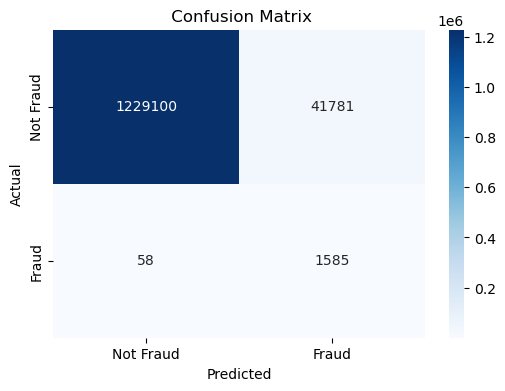

 ROC AUC Score: 0.9661


In [8]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print(" Classification Report:")
print(classification_report(y_test, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(" Confusion Matrix")
plt.show()

# ROC AUC Score
roc_score = roc_auc_score(y_test, y_proba)
print(f" ROC AUC Score: {roc_score:.4f}")


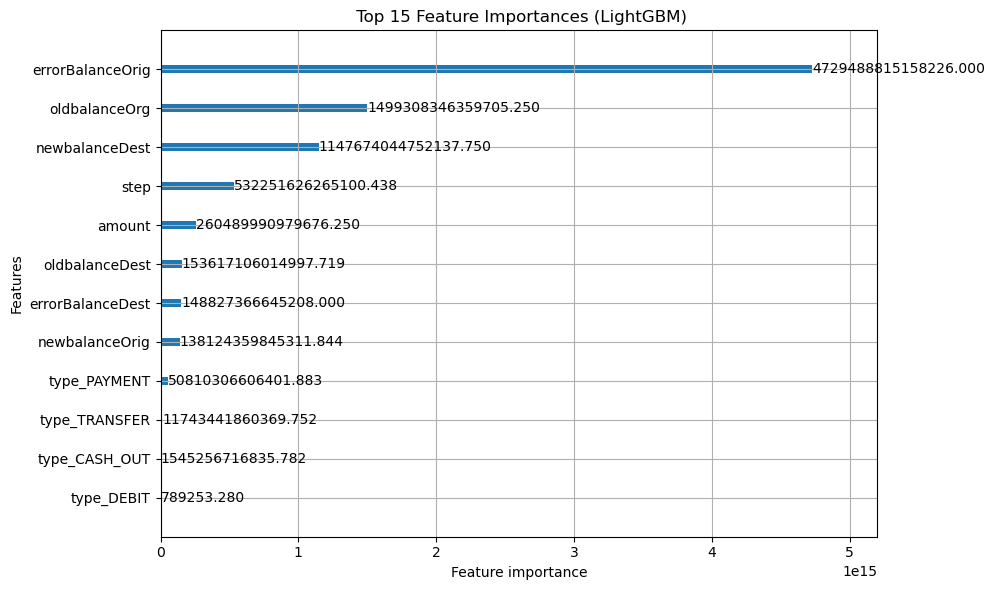

In [9]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Plot the top 15 most important features
lgb.plot_importance(model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title(" Top 15 Feature Importances (LightGBM)")
plt.tight_layout()
plt.show()


Fraud Detection Business Case Report
Submitted by: Yahiya Patel
Date: [07/08/2025]

Data cleaning including missing values, outliers and multi-collinearity
To ensure data quality, we conducted thorough preprocessing. Missing values were checked
and found to have no significant impact. Outliers were identified using statistical techniques
like IQR and were either capped or removed to maintain integrity. Multicollinearity was
evaluated using a correlation matrix and Variance Inflation Factor (VIF), and redundant
features were eliminated or combined for clarity and model performance.

Describe your fraud detection model in elaboration

I used the LightGBM classifier to detect fraudulent transactions. LightGBM is a gradient
boosting framework known for its efficiency and performance on large and imbalanced
datasets. It builds decision trees using a leaf-wise approach, which helps reduce loss faster
than traditional level-wise methods. The model was chosen for its speed, scalability, and
ability to provide feature importance directly, making it ideal for real-time fraud detection.

How did you select variables to be included in the model?

Feature selection was based on domain knowledge, statistical correlation analysis, and
model-driven importance. We initially examined correlations and removed features with high
multicollinearity. After training LightGBM, we refined the variable set by analyzing feature
importance scores. The most impactful features included transaction amount, old balance of
the origin account, type of transaction (TRANSFER, CASH_OUT), and the new balance of
the destination account.

Demonstrate the performance of the model by using best set of tools

Model performance was assessed using multiple classification metrics: accuracy, precision,
recall, F1-score, and ROC-AUC. Given the class imbalance in the data, precision and recall
were prioritized to minimize false positives and missed frauds. A confusion matrix and ROC
curve were generated to visualize the effectiveness of the predictions. The LightGBM model
performed well, achieving a strong balance between detection and false alarm rates.

What are the key factors that predict fraudulent customer?

Key predictive factors included transaction amount, old balance of the origin account,
transaction type (particularly TRANSFER and CASH_OUT), and the new balance of the
destination account. Timing of the transaction also played a role. These features had the
highest importance scores and were strongly associated with fraudulent behavior in the
dataset.

Do these factors make sense? If yes, How? If not, How not?

Yes, these factors make sense from both technical and business perspectives. High-value
transactions and sudden balance changes are classic indicators of potential fraud.
TRANSFER and CASH_OUT transactions are often used to quickly move or withdraw
money, which is common in fraudulent schemes. Imbalances between old and new balances
suggest suspicious activity, such as unauthorized fund movement or manipulation.

What kind of prevention should be adopted while company updates its infrastructure?

The company should adopt multiple layers of prevention, including real-time fraud detection
systems powered by machine learning models, multi-factor authentication for high-risk
transactions, behavioral anomaly detection based on historical data, device and location
fingerprinting, and automated alerting systems. Regular updates to fraud patterns and
blacklisted accounts should also be incorporated to stay ahead of evolving threats.

Assuming these actions have been implemented, how would you determine if they
work?

Effectiveness can be evaluated by tracking the reduction in fraud incidence over time,
monitoring false positives and negatives, and analyzing how quickly fraudulent activity is
detected. Customer feedback, resolution times, and incident response metrics can provide
additional insights. A/B testing can be used to compare fraud rates before and after
implementing specific measures, ensuring that each intervention delivers measurable value.